In [28]:
import csv
import random
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [29]:
vocab_size = 1000
embedding_dim = 16
max_length = 5
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
train_split = 0.7

In [30]:
# Replace the URL with the raw URL of your CSV file
url = "https://raw.githubusercontent.com/DuitDojo-Capstone-Project/DuitDojo_ML/main/text%20classification/data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame to verify the data
df.head()

,Items,Category
0,movie streaming subscription,utility
1,top up dana,utility
2,top up google play,utility
3,top up dana,utility
4,top up google play,utility


In [31]:
items_list = df['Items'].tolist()
category_list = df['Category'].str.strip().tolist()
data_list = list(zip(items_list, category_list))
random.shuffle(data_list)
items_list, category_list = zip(*data_list)

In [32]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(category_list)
one_hot_labels = to_categorical(encoded_labels)

In [33]:
training_size = int(len(items_list)*train_split)
train_items = items_list[:training_size]
train_labels = one_hot_labels[:training_size]
val_items = items_list[training_size:]
val_labels = one_hot_labels[training_size:]

In [34]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_items)
train_sequences = tokenizer.texts_to_sequences(train_items)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_sequences = tokenizer.texts_to_sequences(val_items)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [35]:
print(len(train_padded))
print(len(train_labels))
print(len(val_padded))
print(len(val_labels))

1376
1376
591
591


In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim, input_length=max_length),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padded, train_labels,
                    epochs=100,
                    validation_data=(val_padded, val_labels))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 16)             16000     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 17765 (69.39 KB)
Trainable params: 17765 (69.39 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

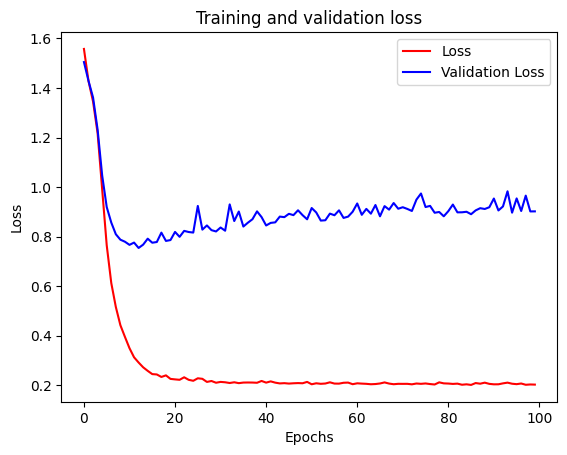

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(100)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

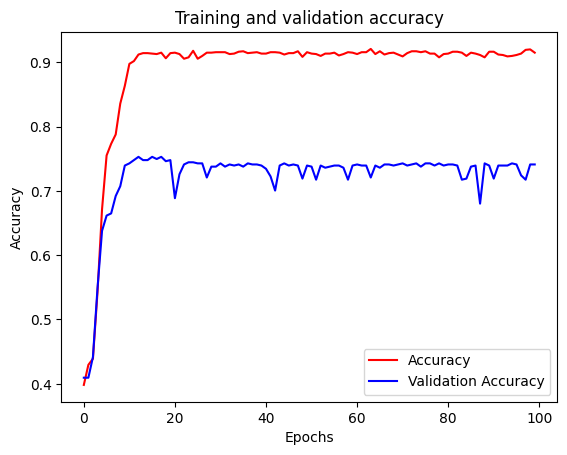

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [39]:
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is 0.00002


In [40]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [41]:
def encode(texts):
  text_sequences = tokenizer.texts_to_sequences(texts)
  text_padded = pad_sequences(text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return text_padded

In [42]:
texts = ['MUSTELA BABY OIL 100ML',
'NASI PUTIH',
'SATE PADANG',
'GULAI CUMI',
'DENDENG BALADO',
'KERUPUK KULIT',
'RENDANG DAGING',
'GULAI HATI',
'MUJAIR BAKAR',
'GULAI OTAK',
'AYAM BAKAR',
'SAMBAL TRI BELAH',
'LALAP SEGAR',
'AYAM PENYET',
'AYAM GORENG',
'AYAM POP',
'GULAI TUNJANG',
'TEH']
padded_inputs = encode(texts)
padded_inputs_tensor = tf.convert_to_tensor(np.array(padded_inputs))
predictions = model.predict(padded_inputs_tensor)

for i, text in enumerate(texts):
    predicted_class = np.argmax(predictions[i])
    predicted_label = label_encoder.classes_[predicted_class]
    print(f"Input Text: {text}, Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 111ms/step
Input Text: MUSTELA BABY OIL 100ML, Predicted Label: others
Input Text: NASI PUTIH, Predicted Label: food
Input Text: SATE PADANG, Predicted Label: food
Input Text: GULAI CUMI, Predicted Label: food
Input Text: DENDENG BALADO, Predicted Label: food
Input Text: KERUPUK KULIT, Predicted Label: food
Input Text: RENDANG DAGING, Predicted Label: food
Input Text: GULAI HATI, Predicted Label: food
Input Text: MUJAIR BAKAR, Predicted Label: others
Input Text: GULAI OTAK, Predicted Label: food
Input Text: AYAM BAKAR, Predicted Label: food
Input Text: SAMBAL TRI BELAH, Predicted Label: food
Input Text: LALAP SEGAR, Predicted Label: others
Input Text: AYAM PENYET, Predicted Label: food
Input Text: AYAM GORENG, Predicted Label: food
Input Text: AYAM POP, Predicted Label: food
Input Text: GULAI TUNJANG, Predicted Label: food
Input Text: TEH, Predicted Label: food
